In [30]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [10]:
# dataset in which we also standardize the data (mean 0, std dev 1)

class SignalDataset(Dataset):
    def __init__(self, file_paths, labels, scaler=None):
        self.file_paths = file_paths
        self.labels = labels
        self.scaler = scaler or StandardScaler()
        self._fit_scaler()

    def _fit_scaler(self):
        all_data = []
        for file_path in self.file_paths:
            data = np.loadtxt(file_path, delimiter=",").astype(np.float32)
            all_data.append(data)
        all_data = np.vstack(all_data)
        self.scaler.fit(all_data)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        data = np.loadtxt(self.file_paths[idx], delimiter=",")
        data = self.scaler.transform(data)
        signal = torch.tensor(data, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return signal, label

In [48]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.first_layer = nn.Linear(3 * 153, 32)
        self.second_layer = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 4)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.first_layer(x))
        x = F.relu(self.second_layer(x))
        x = self.output_layer(x)
        return x

In [59]:
def k_fold_train_validate(NUM_EPOCHS=10, n_splits=5, batch_size=32):
    df_train = pd.read_csv('csvs/train.csv')
    file_paths = df_train['filename'].tolist()
    labels = df_train['label'].tolist()
    file_paths = ['data_long/train/' + path for path in file_paths]
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=475)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    fold_val_accs = np.zeros(shape=(n_splits, NUM_EPOCHS))
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(file_paths)):
        print(f"=== Fold {fold + 1} ===")
    
        train_paths = [file_paths[i] for i in train_idx]
        val_paths = [file_paths[i] for i in val_idx]
        train_labels = [labels[i] for i in train_idx]
        val_labels = [labels[i] for i in val_idx]
    
        train_dataset = SignalDataset(train_paths, train_labels)
        val_dataset = SignalDataset(val_paths, val_labels, scaler=train_dataset.scaler)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    
        model = NeuralNetwork().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_function = nn.CrossEntropyLoss()
    
        for epoch in range(NUM_EPOCHS):
            model.train(True)
            epoch_loss = 0.0
            # training
            for signals_batch, labels_batch in train_dataloader:
                signals_batch, labels_batch = signals_batch.to(device), labels_batch.to(device)
                pred = model(signals_batch)
                loss = loss_function(pred, labels_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
    
            # validation
            model.eval()
            val_preds = []
            val_targets = []
            with torch.no_grad():
                for signals_batch, labels_batch in val_dataloader:
                    signals_batch, labels_batch = signals_batch.to(device), labels_batch.to(device)
                    pred = model(signals_batch)
                    _, predicted_labels = torch.max(pred, 1)
                    val_preds.extend(predicted_labels.cpu().numpy())
                    val_targets.extend(labels_batch.cpu().numpy())
    
            val_accuracy = accuracy_score(val_targets, val_preds)
            print(f"Epoch {epoch + 1}, Validation Accuracy: {val_accuracy:.4f}")
            fold_val_accs[fold, epoch] = val_accuracy
    
        model.train(True)  
    

    plt.style.use('seaborn-v0_8')
    plt.figure(figsize=(10, 6))
    for fold_idx, val_accs in enumerate(fold_val_accs):
        plt.plot(range(1, NUM_EPOCHS + 1), val_accs, label=f"Fold {fold_idx + 1}")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy for Each Fold")
    plt.legend()
    plt.savefig('nn-validation-results.png')
    plt.show()
    
    print(f"Mean val acc: {np.mean(fold_val_accs[:, NUM_EPOCHS-1]):.3f}")

    

In [62]:
def train_test(NUM_EPOCHS=10, batch_size=32):
    
    df_train = pd.read_csv('csvs/train.csv')
    file_paths = df_train['filename'].tolist()
    train_labels = df_train['label'].tolist()
    train_paths = ['data_long/train/' + path for path in file_paths]
    
    df_test = pd.read_csv('csvs/test.csv')
    file_paths = df_test['filename'].tolist()
    test_labels = df_test['label'].tolist()
    test_paths = ['data_long/test/' + path for path in file_paths]
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    test_accs = np.zeros(NUM_EPOCHS)
    

    train_dataset = SignalDataset(train_paths, train_labels)
    test_dataset = SignalDataset(test_paths, test_labels, scaler=train_dataset.scaler)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    model = NeuralNetwork().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_function = nn.CrossEntropyLoss()

    for epoch in range(NUM_EPOCHS):
        model.train(True)
        epoch_loss = 0.0
        # training
        for signals_batch, labels_batch in train_dataloader:
            signals_batch, labels_batch = signals_batch.to(device), labels_batch.to(device)
            pred = model(signals_batch)
            loss = loss_function(pred, labels_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # testing
        model.eval()
        test_preds = []
        test_targets = []
        with torch.no_grad():
            for signals_batch, labels_batch in test_dataloader:
                signals_batch, labels_batch = signals_batch.to(device), labels_batch.to(device)
                pred = model(signals_batch)
                _, predicted_labels = torch.max(pred, 1)
                test_preds.extend(predicted_labels.cpu().numpy())
                test_targets.extend(labels_batch.cpu().numpy())

        test_accuracy = accuracy_score(test_targets, test_preds)
        print(f"Epoch {epoch + 1}, Test Accuracy: {test_accuracy:.4f}")
        test_accs[epoch] = test_accuracy

        model.train(True)  
    

    plt.style.use('seaborn-v0_8')
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, NUM_EPOCHS + 1), test_accs)
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy")
    plt.title("Test Accuracy for Each Epoch")
    plt.savefig('nn-test-results.png')
    plt.show()
    

=== Fold 1 ===
Epoch 1, Validation Accuracy: 0.8050
Epoch 2, Validation Accuracy: 0.8850
Epoch 3, Validation Accuracy: 0.9450
Epoch 4, Validation Accuracy: 0.9700
Epoch 5, Validation Accuracy: 0.9800
Epoch 6, Validation Accuracy: 0.9850
Epoch 7, Validation Accuracy: 0.9850
Epoch 8, Validation Accuracy: 0.9850
Epoch 9, Validation Accuracy: 0.9850
Epoch 10, Validation Accuracy: 0.9850
=== Fold 2 ===
Epoch 1, Validation Accuracy: 0.7700
Epoch 2, Validation Accuracy: 0.8250
Epoch 3, Validation Accuracy: 0.9250
Epoch 4, Validation Accuracy: 0.9700
Epoch 5, Validation Accuracy: 0.9700
Epoch 6, Validation Accuracy: 0.9800
Epoch 7, Validation Accuracy: 0.9900
Epoch 8, Validation Accuracy: 0.9950
Epoch 9, Validation Accuracy: 0.9950
Epoch 10, Validation Accuracy: 0.9950
=== Fold 3 ===
Epoch 1, Validation Accuracy: 0.8100
Epoch 2, Validation Accuracy: 0.8950
Epoch 3, Validation Accuracy: 0.9650
Epoch 4, Validation Accuracy: 0.9750
Epoch 5, Validation Accuracy: 0.9800
Epoch 6, Validation Accuracy

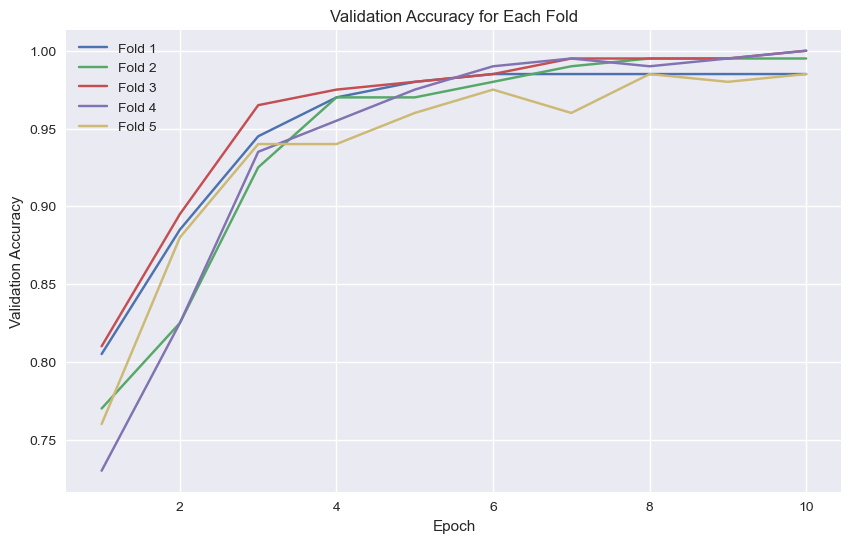

Mean val acc: 0.993


In [63]:
k_fold_train_validate()

Epoch 1, Test Accuracy: 0.8250
Epoch 2, Test Accuracy: 0.9400
Epoch 3, Test Accuracy: 0.9800
Epoch 4, Test Accuracy: 0.9875
Epoch 5, Test Accuracy: 0.9875
Epoch 6, Test Accuracy: 0.9875
Epoch 7, Test Accuracy: 0.9925
Epoch 8, Test Accuracy: 0.9900
Epoch 9, Test Accuracy: 0.9925
Epoch 10, Test Accuracy: 0.9950


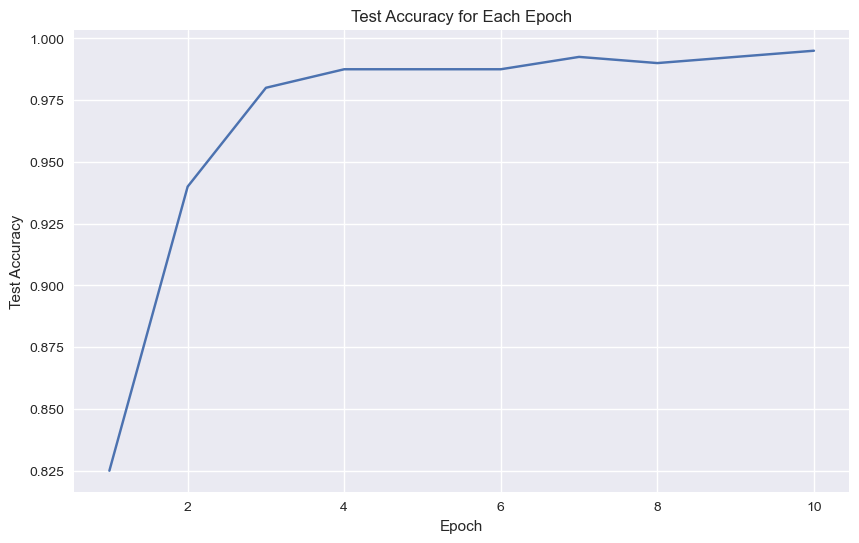

In [64]:
train_test()